# TODO:
Mejorar para hacer el recorrido por los distintos modelos de forma automatica

Almacenar las predicciones para futuros ploteos o visualización de grafica


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

### graficos entrenamiento

In [17]:
num_epochs = 500
losses =np.load('entrenamiento_autoencoder_resized_v1.npz', allow_pickle = True)

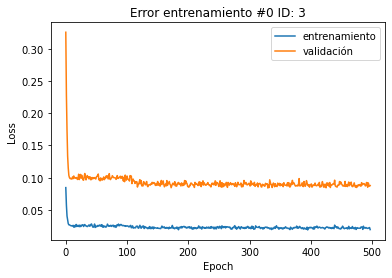

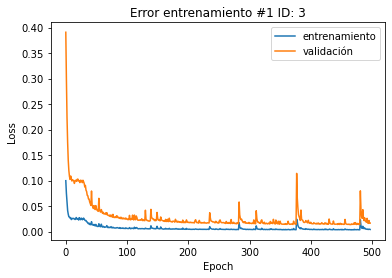

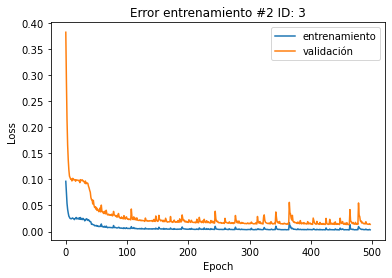

In [18]:
# Ploteo de métricas de error y guarda imagenes 
l = int(len(losses['entrenamiento'])/num_epochs)
for i in range(0,l):
    plt.plot(losses["entrenamiento"][1+i*num_epochs:(i+1)*num_epochs-1], label="entrenamiento")
    plt.plot(losses["validación"][1+i*num_epochs:(i+1)*num_epochs-1], label="validación")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Error entrenamiento #{} ID: 3'.format(i))
    plt.legend()
    plt.savefig('entreamiento_{}_3.png'.format(i))
    plt.show()


### Ploteo objetos 3D

In [1]:
import classification_nbv as cnbv
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
import numpy as np
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [4]:
class voxnet(nn.Module):
    def __init__(self, latent_space, input_shape=(31,31,31)):
        super(voxnet, self).__init__()
        self.latent_space = latent_space       
        
        self.conv1 = nn.Conv3d(1, 32, 5, stride=2)
        self.conv2 = nn.Conv3d(32, 32, 3, stride=1)
        self.mpool = nn.MaxPool3d(2, 2, return_indices=True)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(6912, 128)
        self.linear2 = nn.Linear(128, self.latent_space)
        self.linear3 = nn.Linear(self.latent_space, 128)
        self.linear4 = nn.Linear(128,6912)
        self.uflatten = nn.Unflatten(1, (32, 6, 6, 6))
        self.umpool = nn.MaxUnpool3d(2, stride=2)
        self.tconv1 = nn.ConvTranspose3d(32, 32, kernel_size= 3, stride=1)
        self.tconv2 = nn.ConvTranspose3d(32, 1, kernel_size= 5, stride=2, padding=0)
        
    
    def forward(self, x):
        
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x, index = self.mpool(x)
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = self.uflatten(x)
        x = self.umpool(x, index)
        x = F.leaky_relu(self.tconv1(x))
        x = F.leaky_relu(self.tconv2(x))
        return x

In [2]:
class autoencoder(nn.Module):
    def __init__(self, latent_space, input_shape=(31,31,31)):
        super(autoencoder, self).__init__()
        self.latent_space = latent_space       
        
        self.encoder = nn.Sequential(nn.Conv3d(1, 32, 5, stride=2),
                                     nn.LeakyReLU(),
                                     nn.Conv3d(32, 32, 3, stride=1),
                                     nn.LeakyReLU(),
                                     nn.MaxPool3d(2, 2),
                                     nn.Flatten(),
                                     nn.Linear(6912, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, self.latent_space))
        
        self.decoder1 = nn.Sequential(nn.Linear(self.latent_space, 128),
                                    nn.ReLU(),
                                    nn.Linear(128,6912),
                                    nn.Unflatten(1, (32, 6, 6, 6)),  
                                    nn.LeakyReLU(),
                                    nn.ConvTranspose3d(32, 32, kernel_size= 3, stride=2),
                                    nn.LeakyReLU(),
                                    nn.ConvTranspose3d(32, 16, kernel_size= 5, stride=2, padding=1),
                                    nn.LeakyReLU(),
                                    nn.ConvTranspose3d(16, 1, kernel_size= 5, stride=1, padding=1),
                                    nn.LeakyReLU(),
                                    nn.ConvTranspose3d(1, 1, kernel_size= 3, stride=1)
                                     )
        
        
    
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder1(x)
        return x

In [3]:
print("¿Esta el GPU disponible?:",torch.cuda.is_available())
device = torch.cuda.current_device()

¿Esta el GPU disponible?: True


In [4]:
dataset_folder_val = 'archive/regression_dataset/validation/'
# address
file_vol_val = 'dataset_vol_validation.npy'

# load the inputs
path_input_vol = os.path.join(dataset_folder_val, file_vol_val)
dataset_vol = np.load(path_input_vol)

print("Input validation data size: \n",dataset_vol.shape)

Input validation data size: 
 (3034, 32768)


In [5]:
batch_size = 1000

In [6]:
validation_dataset = cnbv.NBVClassificationDatasetFull(grid_file= dataset_folder_val +file_vol_val, 
                                    nbv_class_file= 'archive/regression_dataset/validation/dataset_pose_validation.npy',
                                    transform=transforms.Compose([
                                    # Reshapes the plain grid
                                    cnbv.To3DGrid(),
                                    #converts to tensors
                                    cnbv.ToTensor()
                                    ]))

validation_loader = DataLoader(validation_dataset, 
                          batch_size=batch_size,
                          #shuffle=True, 
                          num_workers=0)

In [7]:
# Prueba del modelo en un batch de prueba
def net_sample_output():
    model.eval()
    
    # iterate through the test dataset
    for i, sample in enumerate(validation_loader):
        
        if i == 0:
            # get sample data: images and ground truth keypoints
            grids = sample['grid']
            nbvs = sample['nbv_class']

                # convert images to FloatTensors
            grids = grids.type(torch.FloatTensor)

                # wrap them in a torch Variable
            grids = Variable(grids)    
            grids = grids.to(device)

                # forward pass to get net output
            output = model(grids)
            grids = grids.cpu()
            output = output.cpu()

                # get the predicted class from the maximum value in the output-list of class scores
            _, predicted = torch.max(output.data, 1)

                # break after first image is tested
            
            return grids, output, nbvs

In [81]:
path_weights = 'stuff/experimento_2/weights_entrenamiento_autoenc_16_1.pth'
model= voxnet(latent_space = 16).cuda()
model.load_state_dict(torch.load(path_weights))
model.eval()

RuntimeError: Error(s) in loading state_dict for voxnet:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "linear1.weight", "linear1.bias", "linear2.weight", "linear2.bias", "linear3.weight", "linear3.bias", "linear4.weight", "linear4.bias", "tconv1.weight", "tconv1.bias", "tconv2.weight", "tconv2.bias". 
	Unexpected key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.2.weight", "encoder.2.bias", "encoder.6.weight", "encoder.6.bias", "encoder.8.weight", "encoder.8.bias", "decoder1.0.weight", "decoder1.0.bias", "decoder1.2.weight", "decoder1.2.bias", "decoder1.5.weight", "decoder1.5.bias", "decoder1.7.weight", "decoder1.7.bias", "decoder1.9.weight", "decoder1.9.bias", "decoder1.11.weight", "decoder1.11.bias". 

In [8]:
path_weights = 'stuff/experimento_2/weights_entrenamiento_autoenc_64_3.pth'
model= autoencoder(latent_space = 64).cuda()
model.load_state_dict(torch.load(path_weights))
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(2, 2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=6912, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=6912, bias=True)
    (3): Unflatten(dim=1, unflattened_size=(32, 6, 6, 6))
    (4): LeakyReLU(negative_slope=0.01)
    (5): ConvTranspose3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2))
    (6): LeakyReLU(negative_slope=0.01)
    (7): ConvTranspose3d(32, 16, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=(1, 1, 1))
    (8): Lea

In [9]:
torch.cuda.empty_cache()
grid, output, _= net_sample_output()

/media/saulo/datos/Saulo/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(


<Figure size 640x480 with 0 Axes>

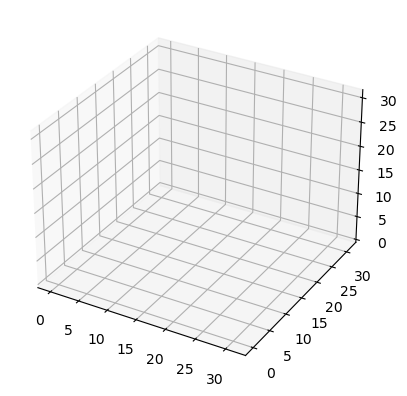

In [10]:
cnbv.showGrid(output[800,0,:31,:31,:31].detach().numpy())

<Figure size 640x480 with 0 Axes>

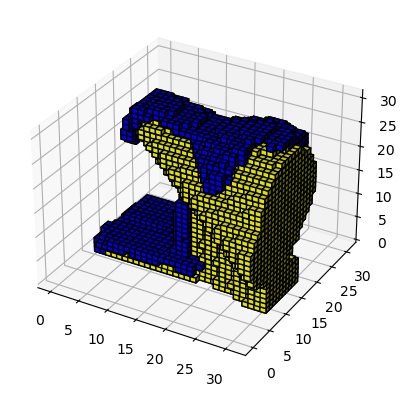

<Figure size 640x480 with 0 Axes>

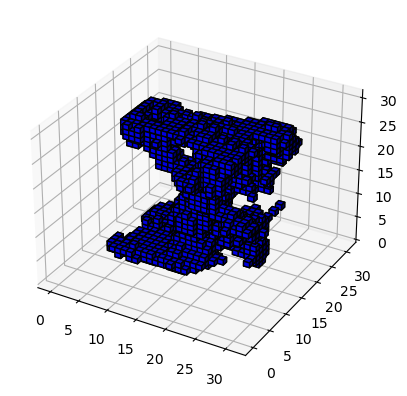

In [62]:
cnbv.showGrid(grid[800,0])
cnbv.showGrid(output[800,0].detach().numpy())